In [29]:
import gdown
import zipfile
import os

def download_from_gdrive(drive_url: str, output_path: str) -> str:
    try:
        print(f"📥 Downloading from Google Drive...\nURL: {drive_url}")
        gdown.download(drive_url, output_path, quiet=False)
    except Exception as e:
        raise RuntimeError(
            "❌ Google Drive blocked the download (quota exceeded).\n"
            "👉 Try downloading manually in your browser and place the file as 'okutama_action.zip'.\n"
            f"Error details: {e}"
        )
    return output_path


def extract_zip(zip_path: str, extract_to: str) -> str:
    """
    Extract a zip file to a target directory.
    Returns the path to the extracted folder.
    """
    if zipfile.is_zipfile(zip_path):
        print(f"📦 Extracting {zip_path} to {extract_to} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(zip_path)
        print(f"✅ Extraction complete! Files are in: {extract_to}")
        return extract_to
    else:
        raise ValueError("❌ The downloaded file is not a valid zip archive.")

def setup_dataset(drive_url: str, output_zip: str, extract_dir: str) -> str:
    """
    High-level function: Download + Extract dataset.
    Returns the dataset root directory.
    """
    zip_path = download_from_gdrive(drive_url, output_zip)
    dataset_dir = extract_zip(zip_path, extract_dir)
    return dataset_dir


In [30]:
import cv2
import os
import glob
import random
import zipfile
from collections import defaultdict
import math

# -------------------- Utilities --------------------
def get_random_color():
    return (random.randint(0,255), random.randint(0,255), random.randint(0,255))

def extract_if_zip(path: str) -> str:
    if os.path.isfile(path) and path.endswith(".zip"):
        extract_dir = path[:-4]
        if not os.path.exists(extract_dir):
            print(f"Extracting {path} -> {extract_dir}")
            with zipfile.ZipFile(path, "r") as z:
                z.extractall(extract_dir)
        else:
            print(f"Zip already extracted at {extract_dir}")
        return extract_dir
    return path

def adjust_bbox(xmin, ymin, xmax, ymax, shrink_factor=0.05):
    """Shrink bbox slightly so it hugs subject more tightly."""
    w = xmax - xmin
    h = ymax - ymin
    if w <= 0 or h <= 0:
        return xmin, ymin, xmax, ymax
    dx = int(round(w * shrink_factor))
    dy = int(round(h * shrink_factor))
    return xmin + dx, ymin + dy, xmax - dx, ymax - dy

def iou(boxA, boxB):
    # compute IoU for sanity (not used heavily but handy)
    (ax1, ay1, ax2, ay2) = boxA
    (bx1, by1, bx2, by2) = boxB
    xA = max(ax1, bx1)
    yA = max(ay1, by1)
    xB = min(ax2, bx2)
    yB = min(ay2, by2)
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = max(0, ax2-ax1) * max(0, ay2-ay1)
    boxBArea = max(0, bx2-bx1) * max(0, by2-by1)
    denom = float(boxAArea + boxBArea - interArea)
    return interArea/denom if denom > 0 else 0.0

# -------------------- Parsing & Preprocessing --------------------
def parse_annotation_file(anno_path):
    """
    Parse Okutama-style annotation file.
    Returns: dict track_id -> list of entries {'frame': int, 'bbox': (x1,y1,x2,y2), 'label': str}
    Note: coordinates are returned as floats (could be normalized or pixels).
    """
    tracks = defaultdict(list)
    if not os.path.exists(anno_path):
        return tracks

    with open(anno_path, "r") as f:
        for ln in f:
            parts = ln.strip().split()
            if len(parts) < 6:
                continue
            # Okutama: track_id xmin ymin xmax ymax frame lost occluded generated "label1" ...
            try:
                track_id = int(parts[0])
                xmin = float(parts[1]); ymin = float(parts[2])
                xmax = float(parts[3]); ymax = float(parts[4])
                frame_id = int(parts[5]) - 1   # convert to 0-based
                # label may start at index 9 onward; but if not available, fallback to empty
                label_tokens = parts[9:] if len(parts) > 9 else []
                label = " ".join([t.strip('"') for t in label_tokens]) or "action"
            except Exception:
                # if parsing fails, skip line
                continue

            tracks[track_id].append({
                "frame": frame_id,
                "bbox": (xmin, ymin, xmax, ymax),
                "label": label
            })
    return tracks

def interpolate_and_smooth_tracks(tracks, frame_w, frame_h, frame_count,
                                  normalized_threshold=1.01,
                                  shrink_factor=0.05, smooth_window=3):
    """
    tracks: dict track_id -> list of entries with 'frame','bbox' (floats), 'label'
    Returns: per_frame_annotations: dict frame_idx -> list of (xmin,ymin,xmax,ymax,label,color)
    Steps:
      - Detect if coords look normalized (<=1.01). If so, scale to pixels using frame_w/frame_h.
      - For each track: sort entries by frame, linearly interpolate missing frames between known frames.
      - Apply moving-average smoothing on bbox coordinates per track.
      - Shrink boxes slightly (shrink_factor), clip to frame bounds, ensure xmin<xmax etc.
    """
    # 1) detect normalization by sampling some boxes
    max_coord = 0.0
    sample_count = 0
    for t_entries in tracks.values():
        for e in t_entries[:10]:
            (x1,y1,x2,y2) = e["bbox"]
            max_coord = max(max_coord, abs(x1), abs(y1), abs(x2), abs(y2))
            sample_count += 1
            if sample_count >= 200:
                break
        if sample_count >= 200:
            break
    normalized = (max_coord <= normalized_threshold)
    if normalized:
        print("Detected normalized coordinates in annotations -> scaling to pixels.")
    else:
        print("Coordinates appear to be in pixels (no scaling).")

    # colors per label
    label_to_color = {}

    # per-track processed dicts: track_id -> dict frame -> [x1,y1,x2,y2,label]
    processed_tracks = {}

    for track_id, entries in tracks.items():
        if not entries:
            continue
        # sort entries by frame
        entries_sorted = sorted(entries, key=lambda x: x["frame"])
        # convert coords to pixel floats
        frame_list = []
        coords_list = []
        label_list = []
        for e in entries_sorted:
            f = e["frame"]
            x1,y1,x2,y2 = e["bbox"]
            if normalized:
                x1 = x1 * frame_w
                x2 = x2 * frame_w
                y1 = y1 * frame_h
                y2 = y2 * frame_h
            frame_list.append(f)
            coords_list.append([float(x1), float(y1), float(x2), float(y2)])
            label_list.append(e.get("label","action"))

        # build a dict for quick frame->coords
        frame_to_coords = {f:coords for f,coords in zip(frame_list, coords_list)}
        frame_to_label = {f:lab for f,lab in zip(frame_list, label_list)}

        # interpolate between consecutive frames
        all_frames = []
        all_coords = []
        all_labels = []
        for i in range(len(frame_list)):
            f0 = frame_list[i]
            c0 = coords_list[i]
            l0 = label_list[i]
            all_frames.append(f0)
            all_coords.append(c0)
            all_labels.append(l0)
            if i < len(frame_list)-1:
                f1 = frame_list[i+1]
                c1 = coords_list[i+1]
                if f1 - f0 > 1:
                    # linear interpolate intermediate frames
                    for t in range(f0+1, f1):
                        ratio = (t - f0) / float(f1 - f0)
                        interp = [
                            c0[j] + ratio * (c1[j] - c0[j]) for j in range(4)
                        ]
                        all_frames.append(t)
                        all_coords.append(interp)
                        all_labels.append(l0)  # carry previous label (best-effort)

        # Now we have an (unsorted) list of frames+coords; sort them
        zipped = list(zip(all_frames, all_coords, all_labels))
        zipped_sorted = sorted(zipped, key=lambda x: x[0])
        frames_sorted = [z[0] for z in zipped_sorted]
        coords_sorted = [z[1] for z in zipped_sorted]
        labels_sorted = [z[2] for z in zipped_sorted]

        # apply moving-average smoothing per coordinate
        w = max(1, int(smooth_window))
        half = w // 2
        smoothed_coords = []
        n = len(coords_sorted)
        for i in range(n):
            start = max(0, i - half)
            end = min(n - 1, i + half)
            cnt = end - start + 1
            avg = [0.0, 0.0, 0.0, 0.0]
            for j in range(start, end+1):
                for k in range(4):
                    avg[k] += coords_sorted[j][k]
            avg = [a / cnt for a in avg]
            smoothed_coords.append(avg)

        # collect into processed_tracks
        proc = {}
        for f,c,label in zip(frames_sorted, smoothed_coords, labels_sorted):
            proc[f] = {"bbox": tuple(c), "label": label}
        processed_tracks[track_id] = proc

        # ensure label->color mapping
        for lab in set(labels_sorted):
            if lab not in label_to_color:
                label_to_color[lab] = get_random_color()

    # Build per-frame dict
    per_frame = defaultdict(list)  # frame_idx -> list of (xmin,ymin,xmax,ymax,label,color)
    for track_id, frame_dict in processed_tracks.items():
        for frame_idx in frame_dict.keys():
            x1,y1,x2,y2 = frame_dict[frame_idx]["bbox"]
            label = frame_dict[frame_idx]["label"]
            # shrink slightly
            x1i, y1i, x2i, y2i = adjust_bbox(int(round(x1)), int(round(y1)),
                                            int(round(x2)), int(round(y2)), shrink_factor=shrink_factor)
            # clip to frame bounds
            x1i = max(0, min(x1i, frame_w-1))
            x2i = max(0, min(x2i, frame_w-1))
            y1i = max(0, min(y1i, frame_h-1))
            y2i = max(0, min(y2i, frame_h-1))
            # ensure proper ordering and at least 2 pixels size
            if x2i <= x1i + 1:
                x2i = min(frame_w-1, x1i + 2)
            if y2i <= y1i + 1:
                y2i = min(frame_h-1, y1i + 2)

            per_frame[frame_idx].append((x1i, y1i, x2i, y2i, label, label_to_color.get(label, get_random_color())))

    return per_frame

# -------------------- Main annotation pipeline --------------------
def annotate_videos(data_dir: str, source_dir: str, output_dir: str,
                    shrink_factor=0.05, smooth_window=3, n_samples=5):
    os.makedirs(output_dir, exist_ok=True)
    samples_dir = os.path.join(output_dir)
    os.makedirs(samples_dir, exist_ok=True)

    # If source is zip -> extract, else keep as-is
    source_dir = extract_if_zip(source_dir)

    # find videos
    video_files = glob.glob(os.path.join(source_dir, "*.mov"))
    if not video_files:
        print(f"No .mov files found in '{source_dir}'.")
        return
    print(f"Found {len(video_files)} videos in '{source_dir}'.")

    for video_path in video_files:
        print("\n" + "="*60)
        base_name = os.path.basename(video_path)
        print(f"Processing video: {base_name}")
        file_stem = os.path.splitext(base_name)[0]
        anno_path = os.path.join(source_dir, f"{file_stem}.txt")
        out_video_path = os.path.join(output_dir, f"{file_stem}_annotated.mp4")

        if not os.path.exists(anno_path):
            print(f"Annotation file not found for {base_name} -> skipping.")
            continue

        # Parse annotation file into per-track data
        tracks = parse_annotation_file(anno_path)
        if not tracks:
            print(f"No valid tracks parsed from {anno_path}. Skipping.")
            continue
        print(f"Parsed {len(tracks)} tracks from annotation file.")

        # Open video to get dimensions and frame_count
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}. Skipping.")
            continue
        fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
        frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"🎞 Video: FPS={fps:.2f}, Size=({frame_w}x{frame_h}), Frames={frame_count}")

        # Preprocess: interpolate + smooth + convert to per-frame annotations
        per_frame_ann = interpolate_and_smooth_tracks(tracks, frame_w, frame_h, frame_count,
                                                      normalized_threshold=1.01,
                                                      shrink_factor=shrink_factor,
                                                      smooth_window=smooth_window)
        print(f"After smoothing/interpolation: {len(per_frame_ann)} frames have annotations.")

        # Prepare VideoWriter
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(out_video_path, fourcc, fps, (frame_w, frame_h))

        # choose sample frames intelligently: prioritize frames that have annotations
        frames_with_ann = sorted(per_frame_ann.keys())
        if frames_with_ann:
            chosen = frames_with_ann.copy()
            random.shuffle(chosen)
            sample_frames = set(chosen[:min(n_samples, len(chosen))])
        else:
            # fallback: random frames from video
            sample_frames = set(random.sample(range(frame_count), min(n_samples, max(1, frame_count))))

        # annotate and write
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame_idx = 0
        saved_samples = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx in per_frame_ann:
                for (xmin, ymin, xmax, ymax, label, color) in per_frame_ann[frame_idx]:
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
                    text = label
                    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    text_bg_tl = (xmin, max(0, ymin - th - 8))
                    text_bg_br = (xmin + tw, ymin)
                    cv2.rectangle(frame, text_bg_tl, text_bg_br, color, -1)
                    cv2.putText(frame, text, (xmin, max(15, ymin - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

            out.write(frame)

            if frame_idx in sample_frames:
                sample_file = os.path.join(samples_dir, f"{file_stem}_sample_{frame_idx}.jpg")
                cv2.imwrite(sample_file, frame)
                saved_samples += 1
                print(f"Saved sample {saved_samples}: {sample_file}")

            frame_idx += 1
            if frame_idx % 200 == 0:
                print(f"  ... processed {frame_idx}/{frame_count} frames ...")

        cap.release()
        out.release()
        print(f"Annotated video written to: {out_video_path}")

        # save a preview (first frame) also
        cap_preview = cv2.VideoCapture(out_video_path)
        ret, pframe = cap_preview.read()
        if ret:
            preview_file = os.path.join(output_dir, f"{file_stem}_preview.jpg")
            cv2.imwrite(preview_file, pframe)
            print(f"Preview saved: {preview_file}")
        cap_preview.release()

    print("\nAll done. Check the outputs and samples folder for results.")


In [31]:
# DRIVE_URL = "https://drive.google.com/uc?id=1fJshjFiK0LNfrLHbGPmhYm9b8WzUKDtY"
# OUTPUT_ZIP = "okutama_action.zip"
# EXTRACT_DIR = "okutama_action"

# dataset_path = setup_dataset(DRIVE_URL, OUTPUT_ZIP, EXTRACT_DIR)
# print(f"Dataset ready at: {dataset_path}")

In [32]:
# # ----------------- Example Usage -----------------
# data_dir = "okutama-action"
# main_output_dir = "okutama-action-outputs"
# source_dir = os.path.join(data_dir, "Sample.zip")   # or "Sample" if already extracted
# output_dir = os.path.join(main_output_dir, "sample-visualize")

# annotate_videos(data_dir, source_dir, output_dir, shrink_factor=0.08, smooth_window=3, n_samples=5)


In [33]:
# import zipfile
# import os

# # Paths (using raw strings to avoid escape issues)
# zip_path = r"okutama-action\TrainSetFrames.zip"
# extract_dir = r"okutama-action\TrainSetFrames"

# # Create directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# # Extract ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# # Count number of files extracted
# num_files = sum(len(files) for _, _, files in os.walk(extract_dir))
# print(f"Frames extracted to: {extract_dir}")
# print(f"Total number of frames extracted: {num_files}")


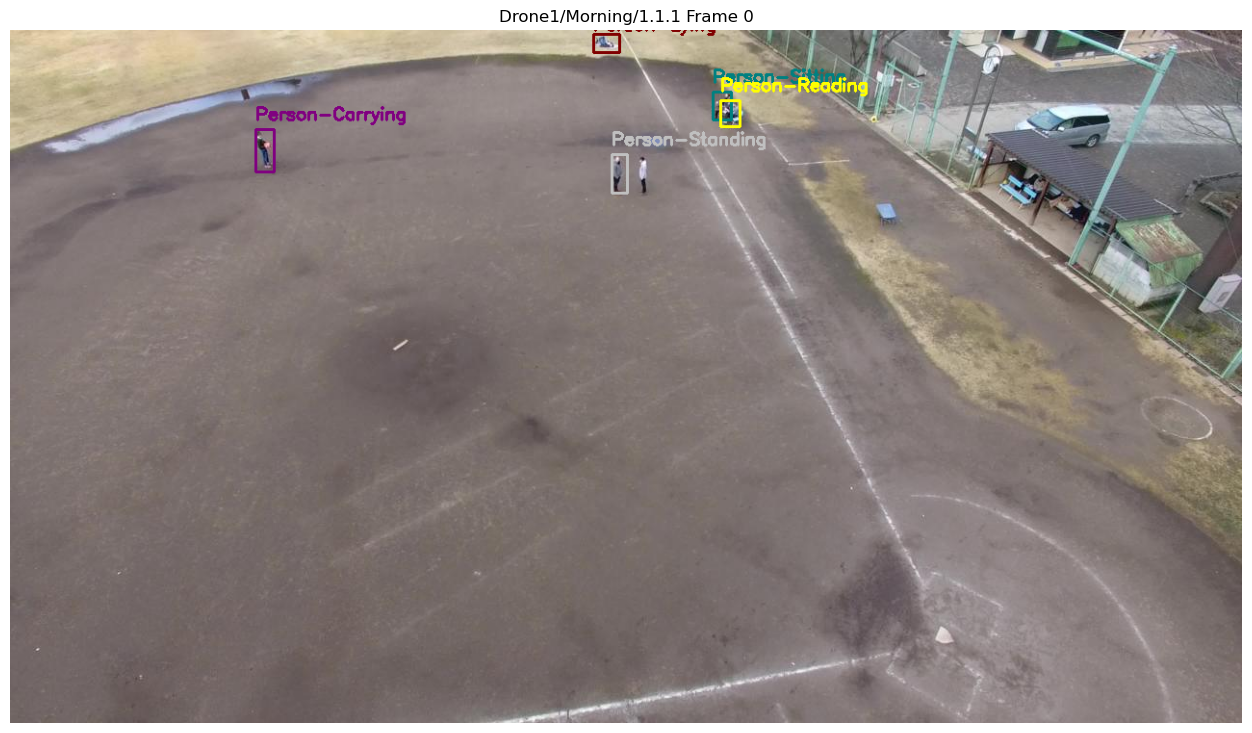

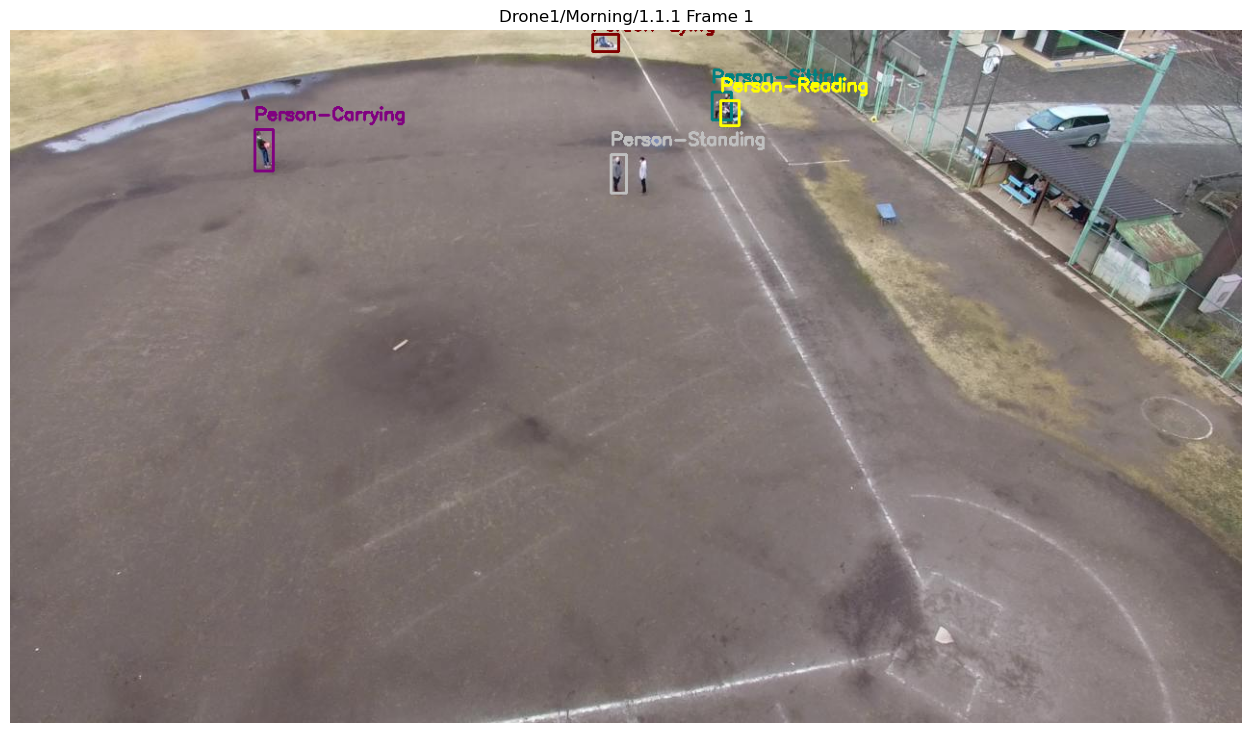

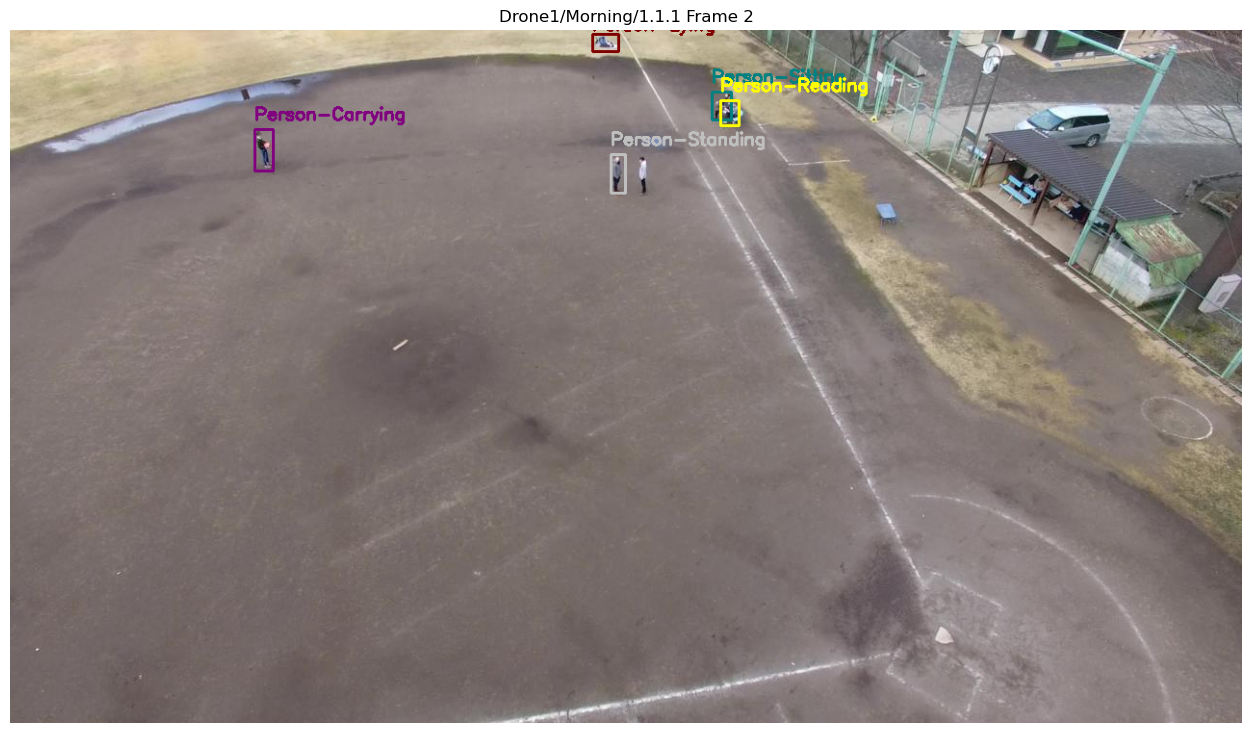

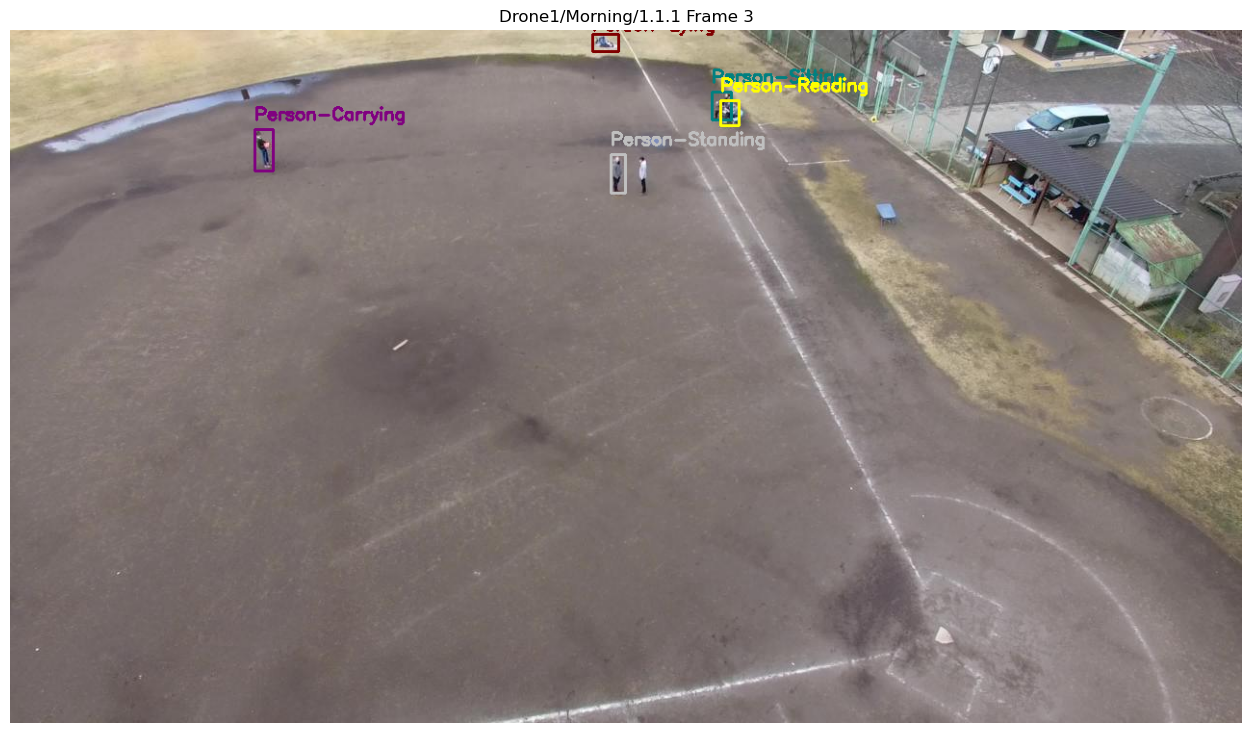

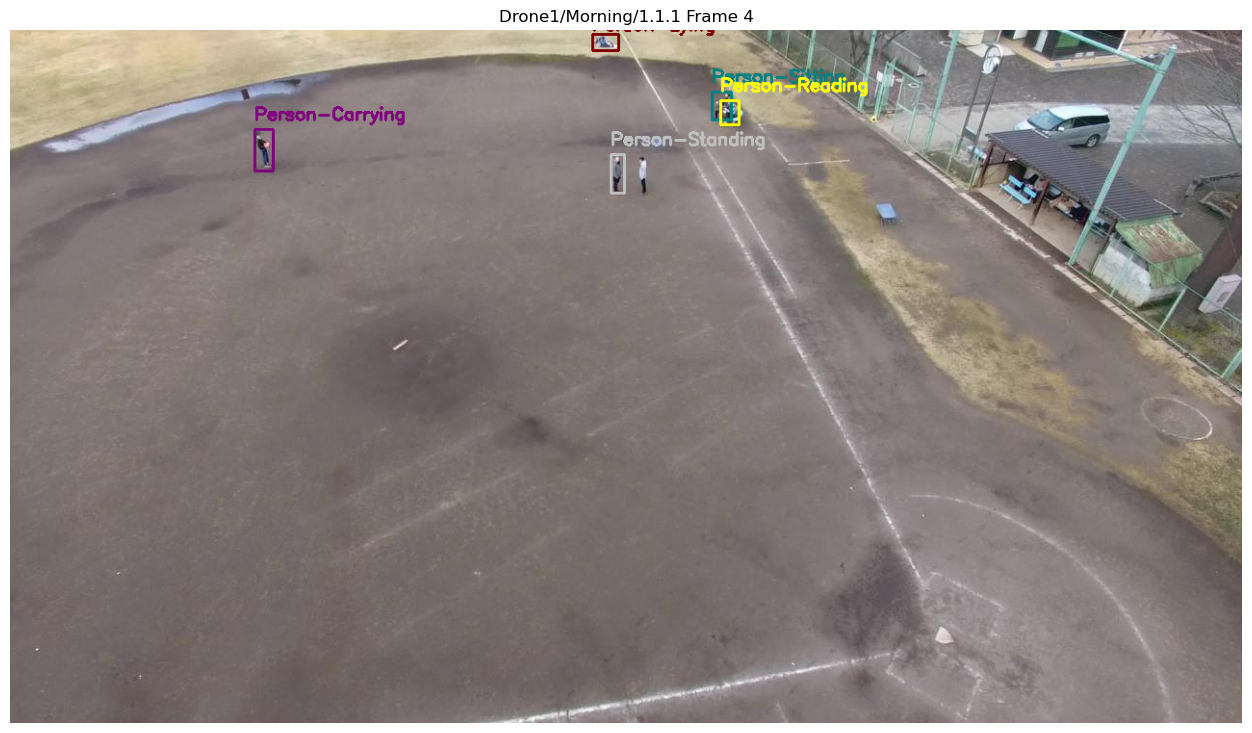

Finished displaying frames with colored bboxes.


In [34]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
frames_root = r"okutama-action/TrainSetFrames"
labels_dir = r"okutama-action/TrainSetFrames/Labels/SingleActionTrackingLabels/3840x2160"

# Original label resolution (always 4K)
ORIG_W, ORIG_H = 3840, 2160

# Number of sample frames to display
max_samples = 5
sample_count = 0

# Define colors for actions
ACTION_COLORS = {
    "Handshaking": (255, 0, 0),       # Red
    "Hugging": (0, 0, 255),           # Blue
    "Reading": (255, 255, 0),         # Cyan
    "Drinking": (0, 255, 255),        # Yellow
    "Pushing/Pulling": (255, 0, 255), # Magenta
    "Carrying": (128, 0, 128),        # Purple
    "Calling": (0, 128, 255),         # Orange
    "Running": (0, 255, 0),           # Green
    "Walking": (128, 128, 0),         # Olive
    "Lying": (128, 0, 0),             # Maroon
    "Sitting": (0, 128, 128),         # Teal
    "Standing": (192, 192, 192),      # Gray
    "O": (255, 192, 203),             # Pink
    "Okutama-Action": (0, 0, 0),      # Black
    "None-Interaction": (128, 128, 128) # Dark Gray
}

DEFAULT_COLOR = (0, 255, 0)  # Bright green if action not in map

def draw_bboxes(img, label_lines, frame_number, max_boxes_per_frame=10):
    h, w, _ = img.shape
    boxes_drawn = 0
    seen_actions = set()  # keep one box per action type

    for line in label_lines:
        if boxes_drawn >= max_boxes_per_frame:
            break

        parts = line.strip().split()
        if len(parts) < 11:
            continue

        # Parse values
        xmin, ymin, xmax, ymax = map(float, parts[1:5])
        line_frame = int(parts[5])
        lost = int(parts[6])
        occluded = int(parts[7])
        label_class = parts[9].strip('"')
        action = parts[10].strip('"') if len(parts) > 10 else ""

        if line_frame != frame_number:
            continue
        if lost == 1:
            continue

        # one box per action per frame
        if action in seen_actions:
            continue
        seen_actions.add(action)

        # Rescale coordinates to frame
        x1 = int(round(xmin * (w / ORIG_W)))
        y1 = int(round(ymin * (h / ORIG_H)))
        x2 = int(round(xmax * (w / ORIG_W)))
        y2 = int(round(ymax * (h / ORIG_H)))

        # Clip
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w - 1, x2), min(h - 1, y2)
        if x2 <= x1 or y2 <= y1:
            continue

        # Pick color for action
        color = ACTION_COLORS.get(action, DEFAULT_COLOR)

        # Draw bbox + label
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, f"{label_class}-{action}", (x1, max(y1 - 10, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        boxes_drawn += 1

    return img


# Walk dataset
for drone in sorted(os.listdir(frames_root)):
    drone_path = os.path.join(frames_root, drone)
    if not os.path.isdir(drone_path):
        continue

    for time_dir in sorted(os.listdir(drone_path)):
        time_path = os.path.join(drone_path, time_dir)
        if not os.path.isdir(time_path):
            continue

        extracted_path = os.path.join(time_path, "Extracted-Frames-1280x720")
        if not os.path.isdir(extracted_path):
            continue

        for video_folder in sorted(os.listdir(extracted_path)):
            video_path = os.path.join(extracted_path, video_folder)
            if not os.path.isdir(video_path):
                continue

            # Label file
            label_file = os.path.join(labels_dir, f"{video_folder}.txt")
            if not os.path.exists(label_file):
                print(f"No label file for {video_folder}")
                continue
            with open(label_file, 'r') as lf:
                label_lines = lf.readlines()

            # Sort frames
            frame_files = sorted(
                [f for f in os.listdir(video_path) if f.lower().endswith(('.jpg', '.png'))],
                key=lambda x: int(os.path.splitext(x)[0])
            )

            for f in frame_files:
                frame_number = int(os.path.splitext(f)[0])
                img_path = os.path.join(video_path, f)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Draw bboxes
                img = draw_bboxes(img, label_lines, frame_number)

                plt.figure(figsize=(16, 9))
                plt.imshow(img)
                plt.title(f"{drone}/{time_dir}/{video_folder} Frame {frame_number}")
                plt.axis('off')
                plt.show()

                sample_count += 1
                if sample_count >= max_samples:
                    break
            if sample_count >= max_samples:
                break
        if sample_count >= max_samples:
            break
    if sample_count >= max_samples:
        break

print("Finished displaying frames with colored bboxes.")
